# Regresión logística multiclase

La regresión logística es normalmente un modelo de clasificación binaria, es decir, distingue entre dos clases (por ejemplo: "spam" vs "no spam").
Pero si se tienen más de dos clases (por ejemplo, clasificar entre 3 marcas de vehículos), se necesita adaptar el modelo. Aquí es donde entra el enfoque One-vs-Rest:

*¿Cómo funciona One-vs-Rest?*
Suponiendo que se tienen tres clases: A, B y C.
Con One-vs-Rest vas a entrenar un clasificador binario por cada clase:
* Clasificador 1: ¿Es A o no? (A vs B+C)
* Clasificador 2: ¿Es B o no? (B vs A+C)
* Clasificador 3: ¿Es C o no? (C vs A+B)
Cada uno de estos clasificadores se entrena por separado usando regresión logística binaria. Luego, cuando se hace una predicción, cada uno da una probabilidad, y se elige la clase con la mayor probabilidad.

Inicialmente importaremos todas las librerias necesarias para la ejecución de nuestros procesos:

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Para poder utilizar sklearn debes instalar scikit-learn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings

# Configurar estilo de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

Ahora cargaremos los datasets que se utilizarán, estos estan en el siguiente orden de carpetas y mostramos los primeros registros del dataset

```bash
|--datasources
   |--parkinsons
```

In [5]:
df = pd.read_csv("./datasources/parkinsons/parkinsons.data")
df = df.drop_duplicates()
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


Una vez revisados algunos datos y cargadas las dependencias necesarios, vamos a explorar la información del dataset

In [6]:
print("Información del dataset:")
print(f"Número de filas: {df.shape[0]}")
print(f"Número de columnas: {df.shape[1]}")
print("\nDistribución de la variable objetivo:")
print(df['status'].value_counts())
print("\nPorcentaje de cada clase:")
print(df['status'].value_counts(normalize=True) * 100)

# Mostramos los tipos de datos por columnas
print("\nTipos de datos en cada columna:")
print(df.dtypes)

# Verificamos si existen valores faltantes
print("\nValores faltantes en cada columna:")
print(df.isnull().sum())


Información del dataset:
Número de filas: 195
Número de columnas: 24

Distribución de la variable objetivo:
status
1    147
0     48
Name: count, dtype: int64

Porcentaje de cada clase:
status
1    75.384615
0    24.615385
Name: proportion, dtype: float64

Tipos de datos en cada columna:
name                 object
MDVP:Fo(Hz)         float64
MDVP:Fhi(Hz)        float64
MDVP:Flo(Hz)        float64
MDVP:Jitter(%)      float64
MDVP:Jitter(Abs)    float64
MDVP:RAP            float64
MDVP:PPQ            float64
Jitter:DDP          float64
MDVP:Shimmer        float64
MDVP:Shimmer(dB)    float64
Shimmer:APQ3        float64
Shimmer:APQ5        float64
MDVP:APQ            float64
Shimmer:DDA         float64
NHR                 float64
HNR                 float64
status                int64
RPDE                float64
DFA                 float64
spread1             float64
spread2             float64
D2                  float64
PPE                 float64
dtype: object

Valores faltantes en cad

Ahora vamos a explorar cada una de las características que podemos encontrar en el dataset en busca de patrones y relaciones en la información, en este caso definiremos una variable que excluya los elementos que no son de tipo numérico para poder generar la matriz de correlación, tomando la variable "status" como objetivo porque es la que indica la presencia  o ausencia de Parkinson y permite encontrar qué características tienen mayor relación con la enfermedad

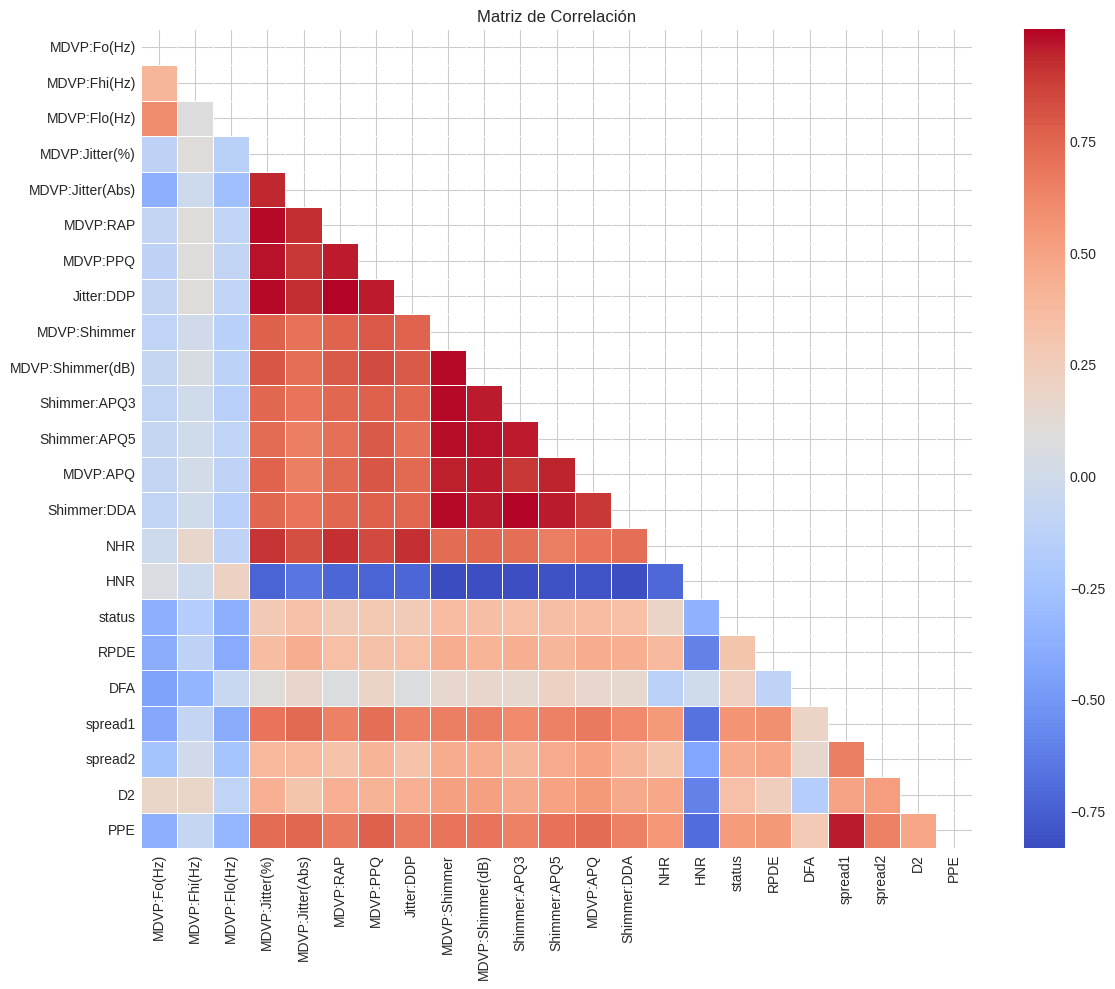

In [7]:

# Definimos las estadísticas descriptivas de las columnas numéricas
df.describe().T.sort_values(by='mean', ascending=False)

# Definimos las dimensiones para los gráficos
plt.figure(figsize=(12, 10))

# Generamos un nuevo dataframe que solo involucra valores numéricos
numeric_df = df.select_dtypes(include=['number'])

# Generamos la matriz de correlación con la variable que tenemos como objetivo: status
correlation_matrix = numeric_df.corr()

mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=False, mask=mask, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.tight_layout()
plt.show()

De esta gráfica de la matriz de correlación, podemos destacar lo siguiente:
Tenemos grupos de variables altamente correlacionada, las que están en rojo, entre diversas medidas de Jitter y Shimmer (MDVP, MDVP, Jitter, etc.), lo cual indica que muchas de estas características que miden variaciones en la voz están fuertemente relacionadas entre sí.

Tenemos grupos de correlaciones negativas, por ejemplo, e observa que HNR (Harmonic to Noise Ratio) tiene correlaciones negativas (en azul) con varias medidas de Jitter y Shimmer, y esto tiene sentido puesto a que HNR mide la calidad de la voz, mientras que Jitter y Shimmer miden irregularidades

También tenemos grupos de variables potencialmente importantes, por ejemplo, las medidas como PPE, spread1, y spread2 parecen tener patrones de correlación interesantes con otras variables, mientras que DFA muestra un patrón de correlación más débil y diferenciado.

In [8]:
# Seleccionamos las primeras  10 características con mayor correlación con 'status'
correlations = numeric_df.corr()['status'].sort_values(ascending=False)
print("Top 10 características con mayor correlación con 'status':")
print(correlations.head(11))  # 11 porque 'status' también está en la lista

Top 10 características con mayor correlación con 'status':
status              1.000000
spread1             0.564838
PPE                 0.531039
spread2             0.454842
MDVP:Shimmer        0.367430
MDVP:APQ            0.364316
Shimmer:APQ5        0.351148
MDVP:Shimmer(dB)    0.350697
Shimmer:APQ3        0.347617
Shimmer:DDA         0.347608
D2                  0.340232
Name: status, dtype: float64


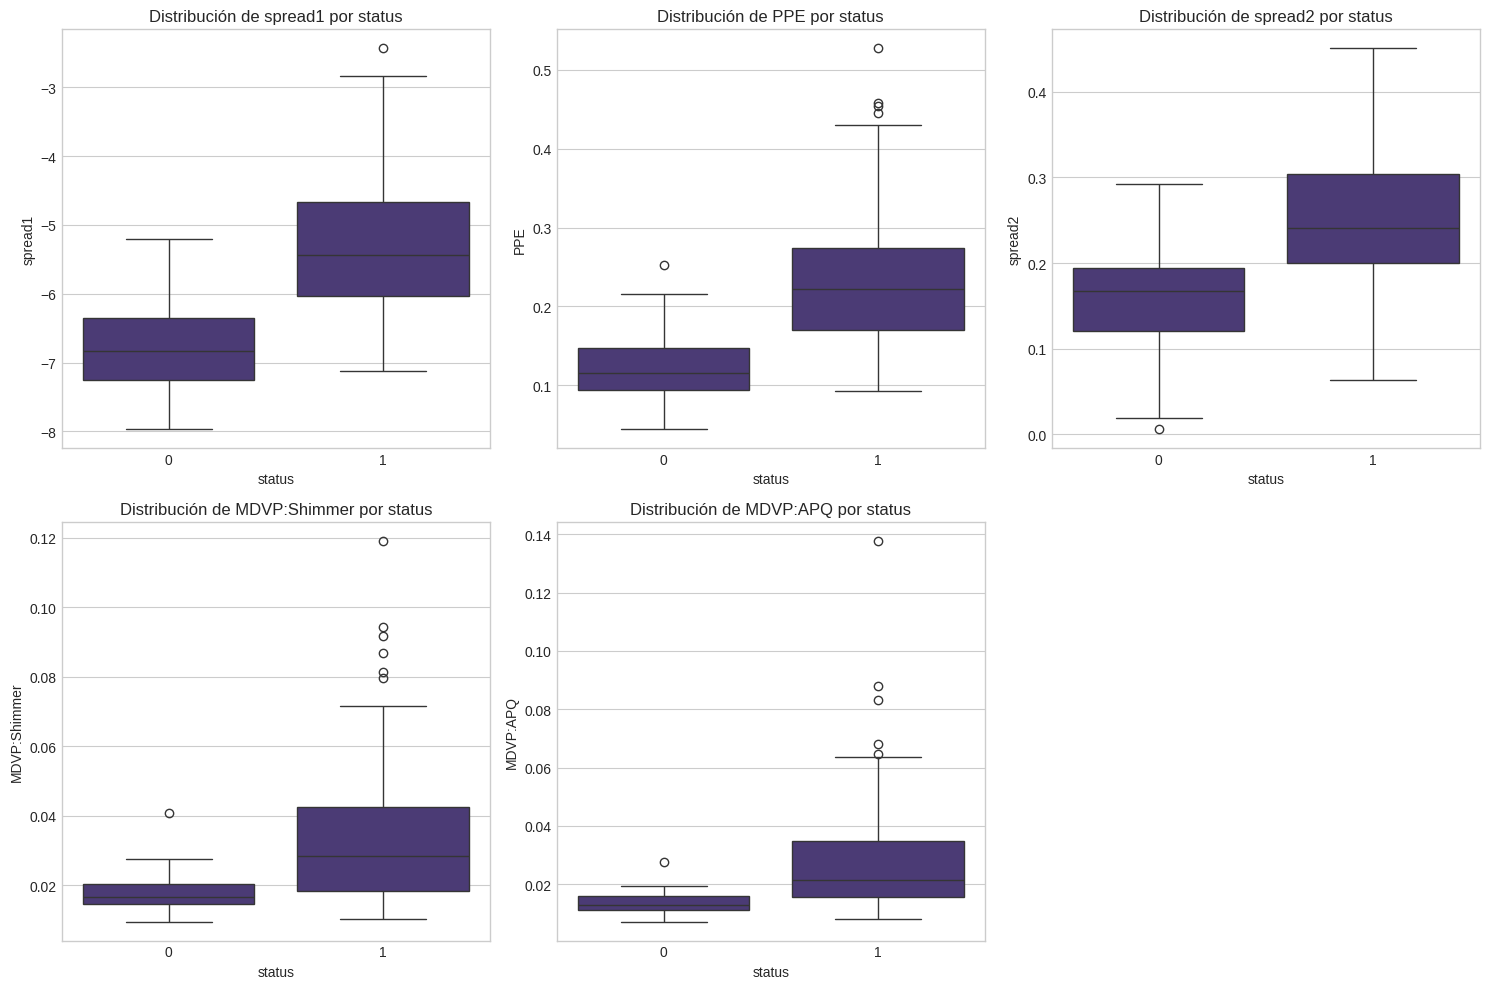

In [9]:
# Obtenemos la distribución de algunas otras características importantes según su correlación con 'status'
top_features = correlations.index[1:6]  # Aquí excluimos 'status'

plt.figure(figsize=(15, 10))
for i, feature in enumerate(top_features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='status', y=feature, data=df)
    plt.title(f'Distribución de {feature} por status')
plt.tight_layout()
plt.show()

Del gráfico de relaciones podemos decir lo siguiente:
#### Distribución de spread1 por status
- Los valores de spread1 son notablemente más bajos en personas sanas (0) que en pacientes con Parkinson (1)
- Personas sanas: Valores principalmente entre -8 y -5
- Personas con Parkinson: Valores entre -7 y -3, con una mediana significativamente más alta

#### Distribución de PPE por status
- PPE (otra medida no lineal de variación de frecuencia fundamental)
- Los valores consistentemente más bajos en personas sanas (principalmente entre 0.05 y 0.15)
- Los valores más altos y con mayor dispersión en personas con Parkinson (aproximadamente entre 0.1 y 0.4)

#### Distribución de spread2 por status
- Hay un contraste significativo: Valores más bajos en personas sanas (mayormente entre 0 y 0.2)
- Valores más altos en personas con Parkinson (principalmente entre 0.1 y 0.4)

#### Distribución de MDVP por status: Shimmer (que es una medida de variabilidad en la amplitud vocal)
- Los valores significativamente más bajos en personas sanas (alrededor de 0.02)
- Los Valores más altos en pacientes con Parkinson (entre 0.02 y 0.04)
- Varios valores atípicos en el grupo con Parkinson, que indica mayor variabilidad

#### Distribución de MDVP por status: APQ (que es otra medida de perturbación de amplitud)
- Patrón similar al Shimmer: valores más bajos en personas sanas
- Valores más altos y mayor dispersión en personas con Parkinson
- Varios valores atípicos en el grupo con Parkinson

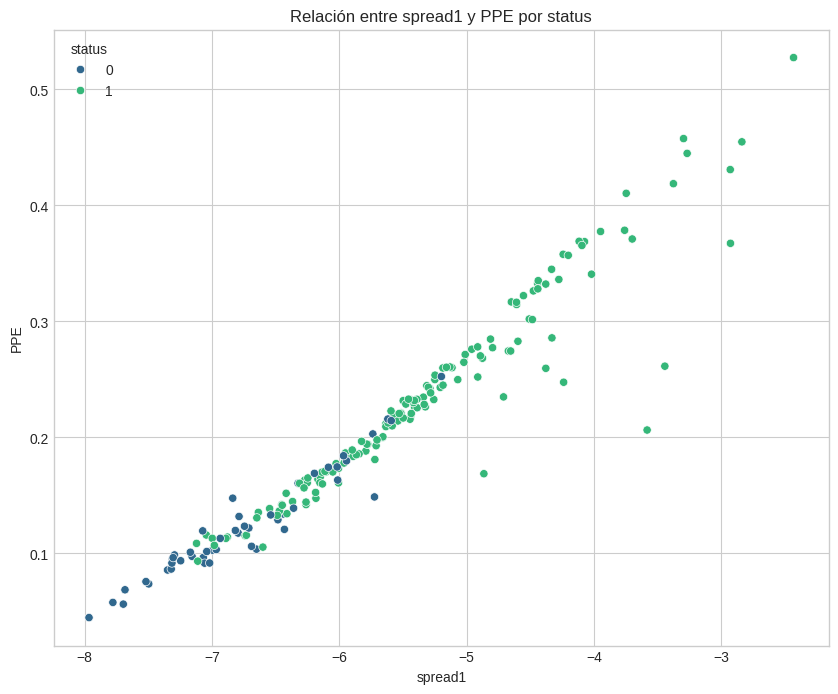

In [10]:
# Obtenemos la relación entre las dos características más correlacionadas con 'status'
plt.figure(figsize=(10, 8))
sns.scatterplot(x=top_features[0], y=top_features[1], hue='status', data=df, palette='viridis')
plt.title(f'Relación entre {top_features[0]} y {top_features[1]} por status')
plt.show()

Del gráfico anterior podemos visualizar la relación entre las características spread1 y PPE, diferenciando entre individuos sanos (los cuales tienen status=0 y se identifican con puntos azules) y personas con enfermedad de Parkinson (las cuales tienen status=1 y se identifican con puntos verdes).

#### Separación entre grupos
- Los individuos sanos se concentran en la esquina inferior izquierda
- Las personas con Parkinson se distribuyen hacia la derecha y arriba


#### Correlación positiva fuerte:
- Existe una relación aproximadamente lineal positiva entre spread1 y PPE
- A medida que spread1 aumenta (se vuelve menos negativo), PPE también aumenta


#### Rangos de valores:
- Personas sanas
  - spread1: aproximadamente entre -8 y -6.5
  - PPE: aproximadamente entre 0.05 y 0.15
- Personas con Parkinson (verde):
  - spread1: principalmente entre -6.5 y -3
  - PPE: principalmente entre 0.1 y 0.5

### Preprocesamiento para Regresión Logística
Vamos a preparar los datos para el entrenamiento del modelo:

In [11]:
# Dividimos las características (X) y la variable objetivo (y)
X = df.drop(['status', 'name'], axis=1)  # Excluimos 'name' ya que es un identificador
y = df['status']

# Dividimos los datos en conjuntos de entrenamiento y prueba (70% entrenamiento, 30% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Estandarizamos las características para mejorar la convergencia del descenso de gradiente
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Dimensiones de X_train_scaled: {X_train_scaled.shape}")
print(f"Dimensiones de X_test_scaled: {X_test_scaled.shape}")
print(f"Dimensiones de y_train: {y_train.shape}")
print(f"Dimensiones de y_test: {y_test.shape}")

Dimensiones de X_train_scaled: (136, 22)
Dimensiones de X_test_scaled: (59, 22)
Dimensiones de y_train: (136,)
Dimensiones de y_test: (59,)


## Implementación de Regresión Logística con Descenso de Gradiente
Una vez hemos preprocesado los datos para el análisis, implementaremos la regresión logística utilizando el Gradient Descent para optimizar los parámetros del modelo

In [13]:
class LogisticRegressionGD:
    """
    Implementamos Regresión Logística con Descenso de Gradiente
    """
    def __init__(self, learning_rate=0.01, n_iterations=1000, tol=1e-4):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.tol = tol
        self.weights = None
        self.bias = None
        self.losses = []
        
    def sigmoid(self, z):
        """Función sigmoid para transformar valores a probabilidades"""
        # Evitamos el desbordamiento numérico
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def compute_loss(self, X, y):
        """Función de pérdida logística (cross-entropy)"""
        m = X.shape[0]
        z = np.dot(X, self.weights) + self.bias
        h = self.sigmoid(z)
        
        # Evitar log(0) agregando un epsilon pequeño
        epsilon = 1e-15
        h = np.clip(h, epsilon, 1 - epsilon)
        
        # Cálculo de la pérdida logística (cross-entropy)
        loss = (-1/m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
        return loss
    
    def fit(self, X, y):
        """Entrenamos el modelo usando descenso de gradiente"""
        # Inicializamos parámetros
        m, n = X.shape
        self.weights = np.zeros(n)
        self.bias = 0
        self.losses = []
        
        # Ejecución del Descenso de gradiente
        for i in range(self.n_iterations):
            # Obtenemos Paso forward
            z = np.dot(X, self.weights) + self.bias
            h = self.sigmoid(z)
            
            # Calculamos gradientes
            dw = (1/m) * np.dot(X.T, (h - y))
            db = (1/m) * np.sum(h - y)
            
            # Actualización de parámetros
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            # Calculamos y almacenamos la pérdida
            loss = self.compute_loss(X, y)
            self.losses.append(loss)
            
            # Verificamos convergencia temprana
            if i > 0 and abs(self.losses[i] - self.losses[i-1]) < self.tol:
                print(f"Convergencia alcanzada en la iteración {i}")
                break
            
            # Imprimimos el progreso cada 100 iteraciones
            if i % 100 == 0:
                print(f"Iteración {i}, Pérdida: {loss:.6f}")
                
        return self
    
    def predict_proba(self, X):
        """Predecimos probabilidades de clase"""
        z = np.dot(X, self.weights) + self.bias
        return self.sigmoid(z)
    
    def predict(self, X, threshold=0.5):
        """Predecimos clase (0 o 1)"""
        return (self.predict_proba(X) >= threshold).astype(int)

Ahora que tenemos una clase con métodos que necesarios para la implementación de la regresión logística, procederemos a implementar la estrategia One-vs-Rest para mostrar el funcionamiento en casos multiclase:

In [14]:
class OneVsRestLogisticRegression:
    """
    Implementamos la estrategia One-vs-Rest para clasificación multiclase
    usando regresión logística con descenso de gradiente
    """
    def __init__(self, learning_rate=0.01, n_iterations=1000, tol=1e-4):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.tol = tol
        self.classifiers = {}
        self.classes = None
        
    def fit(self, X, y):
        """Entrenamos un clasificador binario para cada clase"""
        self.classes = np.unique(y)
        
        # Para cada clase, entrenar un clasificador binario
        for c in self.classes:
            print(f"\nEntrenando clasificador para clase {c}")
            
            # Crear etiquetas binarias (1 para la clase actual, 0 para el resto)
            y_binary = (y == c).astype(int)
            
            # Crear y entrenar un clasificador para esta clase
            clf = LogisticRegressionGD(
                learning_rate=self.learning_rate,
                n_iterations=self.n_iterations,
                tol=self.tol
            )
            clf.fit(X, y_binary)
            
            # Almacenar el clasificador
            self.classifiers[c] = clf
        
        return self
    
    def predict_proba(self, X):
        """PRedecimos probabilidades para cada clase"""
        # Creamos una matriz de probabilidades (muestras x clases)
        proba = np.zeros((X.shape[0], len(self.classes)))
        
        # Predecimos la probabilidad para cada clase
        for i, c in enumerate(self.classes):
            proba[:, i] = self.classifiers[c].predict_proba(X)
            
        return proba
    
    def predict(self, X):
        """PRedecimos la clase con mayor probabilidad"""
        proba = self.predict_proba(X)
        return self.classes[np.argmax(proba, axis=1)]

Ahora que hemos desarrollado la lógica necesaria para la implementación de la regresión logística con optimización por Gradient Descent, procedemos a entrenar el modelo y evaluar su rendimiento

In [15]:
# Entrenamos el modelo con los datos de entrenamiento
model = OneVsRestLogisticRegression(learning_rate=0.1, n_iterations=1000)
model.fit(X_train_scaled, y_train)

# REalizamos predicciones en el conjunto de prueba
y_pred = model.predict(X_test_scaled)

# Evaluamos el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"\nExactitud (Accuracy): {accuracy:.4f}")
print("\nMatriz de Confusión:")
print(conf_matrix)
print("\nInforme de Clasificación:")
print(class_report)


Entrenando clasificador para clase 0
Iteración 0, Pérdida: 0.644723
Iteración 100, Pérdida: 0.331333
Iteración 200, Pérdida: 0.301078
Convergencia alcanzada en la iteración 265

Entrenando clasificador para clase 1
Iteración 0, Pérdida: 0.644723
Iteración 100, Pérdida: 0.331333
Iteración 200, Pérdida: 0.301078
Convergencia alcanzada en la iteración 265

Exactitud (Accuracy): 0.8814

Matriz de Confusión:
[[ 9  6]
 [ 1 43]]

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.90      0.60      0.72        15
           1       0.88      0.98      0.92        44

    accuracy                           0.88        59
   macro avg       0.89      0.79      0.82        59
weighted avg       0.88      0.88      0.87        59



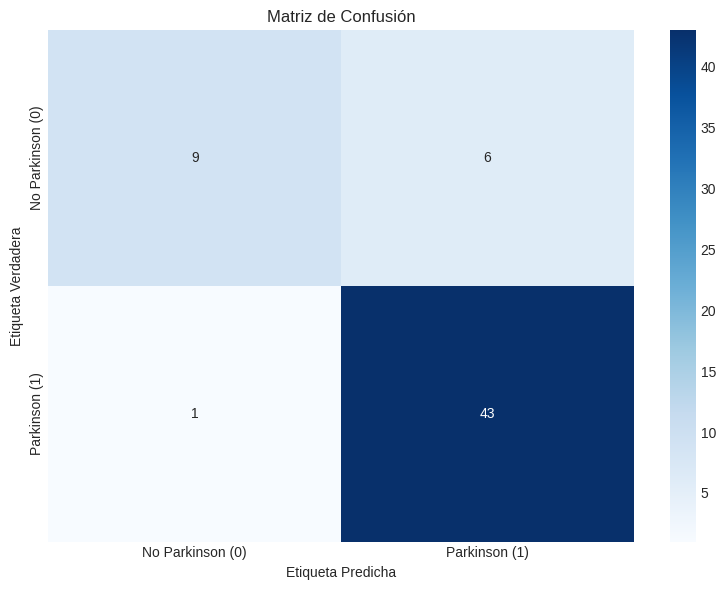

In [16]:
# Mostramos la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Parkinson (0)', 'Parkinson (1)'],
            yticklabels=['No Parkinson (0)', 'Parkinson (1)'])
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.tight_layout()
plt.show()

Una vez hemos ejecutado el proceso, y obtenido la gráfica anterior, podemos observar los resultados:

- Verdaderos Negativos (arriba-izquierda): 9 casos
  - Personas correctamente clasificadas como no teniendo Parkinson
- Falsos Positivos (arriba-derecha): 6 casos
  -Personas sanas incorrectamente clasificadas como teniendo Parkinson
- Falsos Negativos (abajo-izquierda): 1 caso
  - Persona con Parkinson incorrectamente clasificada como sana
- Verdaderos Positivos (abajo-derecha): 43 casos
  - Personas correctamente clasificadas como teniendo Parkinson

Ahora, con esta información podemos explicar el listado de resultados previo al gráfico
- Exactitud (Accuracy): (9 + 43) / (9 + 6 + 1 + 43) = 52/59 ≈ 88.1%
  - Porcentaje total de predicciones correctas
- Sensibilidad/Recall para Parkinson: 43 / (43 + 1) = 43/44 ≈ 97.7%
  - Capacidad del modelo para identificar correctamente a las personas con Parkinson
  - En este caso vemos que es muy alta, lo cual es crucial para un sistema de detección médica
- Especificidad para Parkinson: 9 / (9 + 6) = 9/15 = 60%
  - Capacidad del modelo para identificar correctamente a las personas sanas
  - En este caso vemos que es moderada, indicando cierta tendencia a sobrediagnosticar casos
- Precisión para Parkinson: 43 / (43 + 6) = 43/49 ≈ 87.8%
  - De todos los diagnosticados como Parkinson, qué porcentaje realmente tiene la enfermedad
- Valor predictivo negativo: 9 / (9 + 1) = 9/10 = 90%
  - De todos los diagnosticados como sanos, qué porcentaje realmente está sano

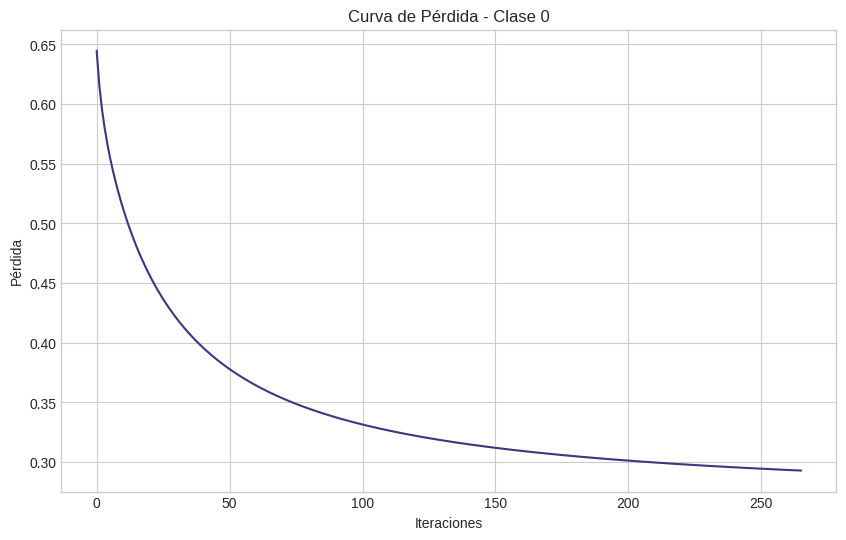

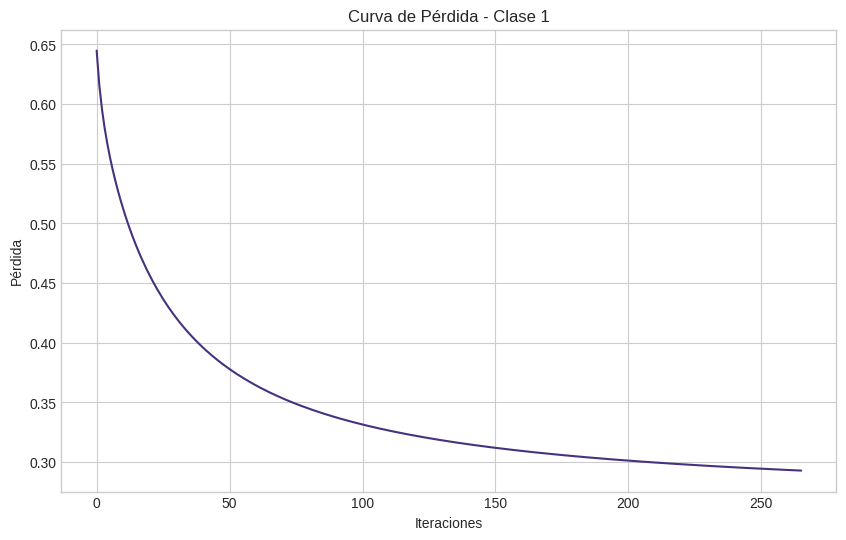

In [17]:
# Mostramos la curva de pérdida durante el entrenamiento
for c in model.classes:
    plt.figure(figsize=(10, 6))
    plt.plot(model.classifiers[c].losses)
    plt.title(f'Curva de Pérdida - Clase {c}')
    plt.xlabel('Iteraciones')
    plt.ylabel('Pérdida')
    plt.grid(True)
    plt.show()

Para finalizar, lo que podemos observar en las gráficas de pérdidas es lo siguiente:
Análisis de las curvas de pérdida:
Imagen 1: Curva de Pérdida - Clase 0 (No Parkinson)
- Muestra tener un valor inicial alto, en el cual la pérdida iniccia alrededor de 0.60-0.65, indicando que las predicciones iniciales son deficientes. La gráfica además muestra un decenso rápido inicial, en el que se observa que existe una disminución pronunciada en las primeras 50 iteraciones, también se puede observar que la pendiente se vuelve más suave en cuanto avanza el entrenamiento, tanto que al llegar al final, la pérdida converge apróximadamente a 0.29-0.30 después de 250 iteraciones.

Imagen 2: Curva de Pérdida - Clase 1 (Parkinson)
Esta curva muestra la evolución de la función de pérdida para el clasificador de la clase 1 (Parkinson):
- Muestra un valor inicial similar con respecto al gráfico de la imagen uno, teniendo una pérdida alta entre 0.60-0.65, que tiene un patrón de descenso rápido inicial, seguido de una convergencia más gradual que se alcanza luego de 250 iteraciones con un valor de convergencia aproximadamente de 0.29-0.30.

Con lo cual podemos concluir que obtuvimos una convergencia exitosa, ya que ambas curvas muestran una clara tendencia descendente y un comportamiento de convergencia, lo que indica que el algoritmo de descenso de gradiente está funcionando correctamente, manteniendo una tasa de prendizaje adecuada que se interpreta por la forma suave de las curvas, mostrando que no es tan alta para generar oscilaciones, ni tan bajas como para volver la convergencia más lenta de lo ideal, alcanzando su convergencia con un número adecuado de iteraciones.

In [18]:
import joblib

# se guarda el modelo y el escalador
joblib.dump(model, "interface/modelo_parkinson.pkl")
joblib.dump(scaler, "interface/scaler_parkinson.pkl")

# para poder usar todas las comlumnas excepto las no numericas name y status
features = df.columns.drop(['name', 'status']).tolist()
joblib.dump(features, "interface/features_parkinson.pkl")

print("archivos creados correctamente")


archivos creados correctamente
